# Calculating transit timing variations

In this example we will be using heyoka.py's [event detection](<./Event detection.ipynb>) system to find the transit times in a two-planet system. This example is directly inspired by a [notebook](https://rebound.readthedocs.io/en/latest/ipython_examples/TransitTimingVariations/) in the documentation of the [REBOUND](https://rebound.readthedocs.io) software package.

We begin as usual with importing heyoka.py and a couple of extra useful modules:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np

Next, we define the initial conditions for the two planets in the system. The inner planet is on a low-eccentricity orbit, while the outer planet is on a circular orbit. Both orbits have zero inclination, so that the motion is constrained to the $xy$ plane. We use adimensional units ($G=1$), the mass of the central star is $1$ and both planets have a mass of $10^{-5}$:

In [2]:
# Initial cartesian conditions for the two planets.
# We use pykep to convert from Keplerian elements.
r1, v1 = pk.par2ic([1.0, 0.1, 0.0, 0.0, 0.25, 0.0])
r2, v2 = pk.par2ic([1.757, 0.0, 0.0, 0.0, 0.0, 0.0])

# Masses of the 3 bodies in the system.
masses = np.array([1, 1e-5, 1e-5])

We can now proceed to the definition of the system of differential equations via the ``model.nbody()`` helper:

In [3]:
sys = hy.model.nbody(3, masses=masses)

The next step is the definition of the event for the detection of the planetary transit. In this setup, we assume that the observer of the system is in the direction of the positive $x$ axis, so that a planetary transit happens when the $y$ coordinate of the planet is zero. Thus, in order to detect the transit of the inner planet, we will use the trivial event equation

$$
y_1 = 0.
$$

Because $y_1$ is zero also when the planet transits *behind* the star, we will further constrain the event by imposing a *positive* direction for the event. That is, the event will trigger only if $y_1 = 0$ and the value of $y_1$ is switching from negative to positive. Alternatively (and more robustly), we could compute the value of $x_1$ when the event triggers via dense output and ignore the event if $x_1<0$, however for this simple example specifying the event direction will suffice.

Finally, we will log the trigger time of each event in a global list for further analysis.

Let us see the definition of the event:

In [4]:
# Global list of transit times.
tt_list = []


# The callback that will be invoked
# when a transit is detected.
def cb(ta, time, d_sgn):
    # Append the transit time to the
    # global list.
    tt_list.append(time)


# Define the event object.
tt_event = hy.nt_event(
    hy.expression("y_1"),  # The event equation.
    cb,  # The callback.
    direction=hy.event_direction.positive,  # The event direction.
)

We can now proceed to the creation of the integrator object. After creation, we will adjust the system state so that the centre of mass of the system is in the origin with zero velocity:

In [5]:
ta = hy.taylor_adaptive(
    sys, [0.0] * 6 + list(r1) + list(v1) + list(r2) + list(v2), nt_events=[tt_event]
)

# Adjust the COM.
com_x = np.sum(ta.state[0::6] * masses) / np.sum(masses)
com_y = np.sum(ta.state[1::6] * masses) / np.sum(masses)
com_z = np.sum(ta.state[2::6] * masses) / np.sum(masses)

com_vx = np.sum(ta.state[3::6] * masses) / np.sum(masses)
com_vy = np.sum(ta.state[4::6] * masses) / np.sum(masses)
com_vz = np.sum(ta.state[5::6] * masses) / np.sum(masses)

ta.state[0::6] -= com_x
ta.state[1::6] -= com_y
ta.state[2::6] -= com_z
ta.state[3::6] -= com_vx
ta.state[4::6] -= com_vy
ta.state[5::6] -= com_vz

Let us now propagate the system state for a few time units. Whenever a transit is detected, the callback will be invoked and the global list of transit times will be updated:

In [6]:
ta.propagate_until(1100.0)

(<taylor_outcome.time_limit: -4294967299>,
 0.22961192655196333,
 0.4928525973770144,
 3344,
 None)

We can now proceed to the analysis of the transit times. First we will run a linear fit to remove the linear trend from the transit times:

In [7]:
N = len(tt_list)

A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, tt_list, rcond=-1)[0]

We are now ready to visualize the transit time variations (TTVs):

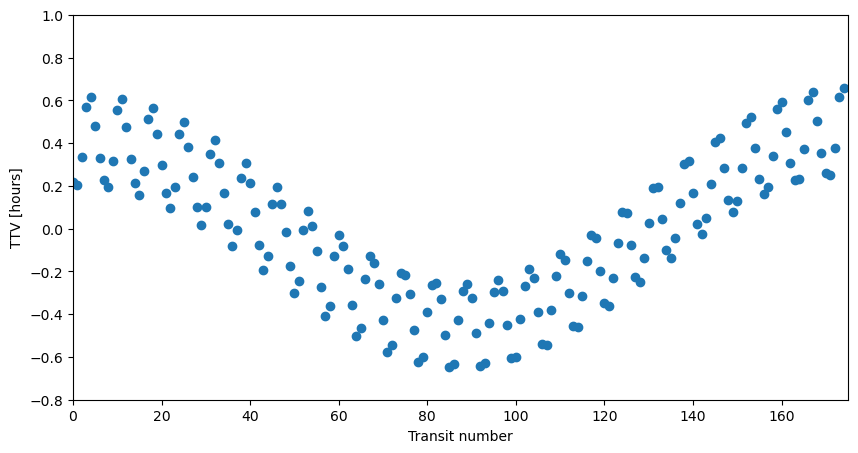

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.set_xlim([0, N])
ax.set_ylim([-0.8, 1.0])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(
    range(N),
    (np.array(tt_list) - m * np.array(range(N)) - c) * (24.0 * 365.0 / 2.0 / np.pi),
);

The transit times deviate from a purely linear behaviour because of the perturbations induced onto the inner planet by the outer planet.